# Sentiment analys med OpenAI och distilbert

In [1]:
import tensorflow as tf
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import pandas as pd
from sklearn.model_selection import train_test_split
import utils as func


Provar lite distilbert

In [3]:
# Load a pretrained tokenizer (e.g., DistilBERT)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# List of multiple texts
texts = [
    "hello Daniel, how are you?",
    "I love using DistilBERT! It's fast and accurate. Says Daniel.",
    "Daniel says, this product is terrible.",
    "Transformers are very useful for NLP tasks.",
    "The movie Andaz Apna Apna in my books is the top 5 intelligent comedy movies ever made in Bollywood perhaps even Hollywood. <br /><br />When the movie released i was a 8 year old and I heard it was a flop but I never understood till now why was it a flop...but let me tell you one thing...this movie would have more money by selling home Cassettes and DVDs and by showing in TV movie channels than any hit movie in theaters. This movie has been shown countless times in Movie channels and I think even now the public love and the TV producers keep repeating the movie again and again. I personally have watched the entire movie more than 80 -100 times and I still love it.....<br /><br />The performance by both Aamir khan as Amar and Salman khan as Prem is mind blowing but i especially liked the performance of Aamir khan as a street smart guy....his dialogs in the movie are Hilarious... the story is simple and heres how it goes.....<br /><br />Amar and Prem are poor , lazy chaps and come from a poor family of tailors and Amars father is a barber. Then they both get a news that a Millionaire 's daughter from London is coming to India to look for a suitable match ...both Amar and Prem think that this is a brilliant opportunity to become super rich.....therefore they both head out to woo Raveena Tandon..(the millionaires daughter)......in their journey they both hate each other and each one of them try to fool the other in order to marry Raveena.....the comedy scenes in between are so hilarious that you would need a glass of water to stop the pain in your stomach by laughing.......and then there is Raveenas Uncle (Millionaire's look alike brother) Teja who wants to take revenge from Raveenas father.....since he is broke and Raveenas dad is a millionaire......his plans include kidnapping Raveena to blackmail Raveenas dad for which he hires 2 butlers.....<br /><br />but later on we get to know that there is a twist in the movie (watch the movie to know).......then there is Shakti Kapoor as crime master Gogo who is also incredibly funny......<br /><br />The thing which stood out for me were the dialogs in the movie which has become a legend of sorts.....Aamir khan uses his  ' aaila  '  brilliantly and Salman goes like  ' OOima  ' ........and for Gogo there is  '  Jab Raat Ko Bacha Soota Nahi Hain to Ma Bolti Hain Ki Sooja Nahi to Gogo Aa Jaega '  ......each and every scene is so funny......<br /><br />I especially liked the one in which Aamir khan and Salman goto get Raveena from Teja and they both go in a Luna having  ' chillar '  money in a bag....that scene is so funny..<br /><br />I recommend anyone who understands Hindi or Urdu to watch this movie ......this is one movie that I would recommend having a DVD and you will never regret......",
    "Andaz Apna Apna is considered one of the most intelligent comedies ever made in Bollywood, potentially rivaling even Hollywood comedies. Despite being a commercial flop upon release, the film gained immense popularity over time, making significant revenue through home media sales and repeated TV broadcasts. The reviewer shares their personal experience, having watched the film more than 80 times and still loving it. The story follows Amar (Aamir Khan) and Prem (Salman Khan), two lazy, poor men who dream of becoming rich by marrying Raveena, the daughter of a millionaire. Both set off to woo her, engaging in hilarious schemes to outsmart each other. Alongside their antics, the movie introduces Teja, Raveena’s uncle who plots to kidnap her for ransom, and Crime Master Gogo (Shakti Kapoor), a memorable villain known for his comedic dialogues. The film’s standout elements are its witty dialogues, such as Aamir’s iconic 'aaila' and Salman’s 'ooima,' which have become legendary. The reviewer highlights memorable scenes, especially one where Amar and Prem attempt to rescue Raveena with a bag of small change. They strongly recommend this timeless comedy classic to anyone who understands Hindi or Urdu, calling it a must-have DVD for guaranteed entertainment."
]

# Tokenize the texts
tokenized_texts = tokenizer(texts, padding=True, truncation=False, return_tensors="tf")

# Count the number of tokens for each text
num_tokens = [len(tokens) for tokens in tokenized_texts['input_ids']]

# Print the number of tokens for each text
for i, tokens in enumerate(num_tokens):
    print(f"Text {i+1}: {tokens} tokens")


Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


Text 1: 748 tokens
Text 2: 748 tokens
Text 3: 748 tokens
Text 4: 748 tokens
Text 5: 748 tokens
Text 6: 748 tokens


In [4]:
def count_tokens(text):
    # Tokenize the text
    tokenized_text = tokenizer(text, padding=True, truncation=False, return_tensors="tf")
    # Count the number of tokens
    num_tokens = len(tokenized_text['input_ids'][0])
    return num_tokens

# Example usage
example_text = "This is an example sentence to count the number of tokens."
print(f"Number of tokens: {count_tokens(example_text)}")

Number of tokens: 15


In [4]:
tokenized_texts

{'input_ids': <tf.Tensor: shape=(6, 748), dtype=int32, numpy=
array([[  101,  7592,  3817, ...,     0,     0,     0],
       [  101,  1045,  2293, ...,     0,     0,     0],
       [  101,  3817,  2758, ...,     0,     0,     0],
       [  101, 19081,  2024, ...,     0,     0,     0],
       [  101,  1996,  3185, ...,  1012,  1012,   102],
       [  101,  1998, 10936, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6, 748), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [6]:
#tokens = tokenizer(tokenized_texts, return_tensors="tf")

# Convert token IDs back to text
decoded_text = tokenizer.decode(tokenized_texts['input_ids'][2])
decoded_text

'[CLS] daniel says, this product is terrible. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [7]:
# Load the sentiment analysis pipeline with a DistilBERT model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", framework="tf")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [8]:
# Test the pipeline with some sample sentences
sentences = [
    "I love using DistilBERT! It's so fast and accurate.",
    "This product is terrible. I'm very disappointed.",
    "This is very good, not!",
    "This is very good. (not!)",
    "Things are going well.",
    "Here in Brazil the sun is shining and the weather is hot.",
    "Here in Sweden the weather is cold and the snow is falling.",
    "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",
    "A wonderful little production. The filming technique is very unassuming - very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only 'has got all the polari' but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",
    "I have to say I was really looking forward on watching this film and finding some new life in it that would separate it from most dull and overly crafted mexican films. I have no idea why but I trusted Sexo, Pudor y Lagrimas to be the one to inject freshness and confidence to our non-existent industry. Maybe it was because the soundtrack(which I listened to before I saw the film) sounded different from others, maybe it was because it dared to include newer faces(apart from Demian Bichir who is always a favorite of mexican film directors) and supposedly dealed within it's script with modern social behaviour, maybe because it's photography I saw in the trailers was bright and realistic instead of theatrical. The film turned out to be a major crowd pleaser, and a major letdown. What Serrano actually deals here with is the very old fashioned 'battle of the sexes' as in 'all men are the same' and 'why is it that all women...;' blah,blah,blah. Nothing new in it, not even that, it uses so much common ground and clichè that it eventually mocks itself without leaving any valuable reflexion on the female/male condition. Full of usual tramps on the audience like safe gags about the clichès I talked about before(those always work, always) and screaming performances(it is a well acted film in it's context)..and by screaming I mean, literally. The at first more compelling characters played by Monica Dionne and Demian Bichir turn out to be according to Serrano the more pathetic ones. I completely disagree with Serrano, they shouldn't have been treated that way only to serve as marionettes for his lesson to come through...he made sure we got HIS message and completely destroyed their roles that were the only solid ground in which this story could have stood. Anyway, it is after all, a very entertaining film at times and you will probably have a good time seeing it (if you accept to be manipulated by it)",
    #"The movie Andaz Apna Apna in my books is the top 5 intelligent comedy movies ever made in Bollywood perhaps even Hollywood. <br /><br />When the movie released i was a 8 year old and I heard it was a flop but I never understood till now why was it a flop...but let me tell you one thing...this movie would have more money by selling home Cassettes and DVDs and by showing in TV movie channels than any hit movie in theaters. This movie has been shown countless times in Movie channels and I think even now the public love and the TV producers keep repeating the movie again and again. I personally have watched the entire movie more than 80 -100 times and I still love it.....<br /><br />The performance by both Aamir khan as Amar and Salman khan as Prem is mind blowing but i especially liked the performance of Aamir khan as a street smart guy....his dialogs in the movie are Hilarious... the story is simple and heres how it goes.....<br /><br />Amar and Prem are poor , lazy chaps and come from a poor family of tailors and Amars father is a barber. Then they both get a news that a Millionaire 's daughter from London is coming to India to look for a suitable match ...both Amar and Prem think that this is a brilliant opportunity to become super rich.....therefore they both head out to woo Raveena Tandon..(the millionaires daughter)......in their journey they both hate each other and each one of them try to fool the other in order to marry Raveena.....the comedy scenes in between are so hilarious that you would need a glass of water to stop the pain in your stomach by laughing.......and then there is Raveenas Uncle (Millionaire's look alike brother) Teja who wants to take revenge from Raveenas father.....since he is broke and Raveenas dad is a millionaire......his plans include kidnapping Raveena to blackmail Raveenas dad for which he hires 2 butlers.....<br /><br />but later on we get to know that there is a twist in the movie (watch the movie to know).......then there is Shakti Kapoor as crime master Gogo who is also incredibly funny......<br /><br />The thing which stood out for me were the dialogs in the movie which has become a legend of sorts.....Aamir khan uses his  ' aaila  '  brilliantly and Salman goes like  ' OOima  ' ........and for Gogo there is  '  Jab Raat Ko Bacha Soota Nahi Hain to Ma Bolti Hain Ki Sooja Nahi to Gogo Aa Jaega '  ......each and every scene is so funny......<br /><br />I especially liked the one in which Aamir khan and Salman goto get Raveena from Teja and they both go in a Luna having  ' chillar '  money in a bag....that scene is so funny..<br /><br />I recommend anyone who understands Hindi or Urdu to watch this movie ......this is one movie that I would recommend having a DVD and you will never regret......",
    "Andaz Apna Apna is considered one of the most intelligent comedies ever made in Bollywood, potentially rivaling even Hollywood comedies. Despite being a commercial flop upon release, the film gained immense popularity over time, making significant revenue through home media sales and repeated TV broadcasts. The reviewer shares their personal experience, having watched the film more than 80 times and still loving it. The story follows Amar (Aamir Khan) and Prem (Salman Khan), two lazy, poor men who dream of becoming rich by marrying Raveena, the daughter of a millionaire. Both set off to woo her, engaging in hilarious schemes to outsmart each other. Alongside their antics, the movie introduces Teja, Raveena’s uncle who plots to kidnap her for ransom, and Crime Master Gogo (Shakti Kapoor), a memorable villain known for his comedic dialogues. The film’s standout elements are its witty dialogues, such as Aamir’s iconic 'aaila' and Salman’s 'ooima,' which have become legendary. The reviewer highlights memorable scenes, especially one where Amar and Prem attempt to rescue Raveena with a bag of small change. They strongly recommend this timeless comedy classic to anyone who understands Hindi or Urdu, calling it a must-have DVD for guaranteed entertainment.",

]
# Get predictions
results = sentiment_pipeline(sentences)
# Print the results
for sentence, result in zip(sentences, results):
    print(f"Sentence: '{sentence}' => Sentiment: {result['label']}, Confidence: {result['score']:.2f}")

Sentence: 'I love using DistilBERT! It's so fast and accurate.' => Sentiment: POSITIVE, Confidence: 1.00
Sentence: 'This product is terrible. I'm very disappointed.' => Sentiment: NEGATIVE, Confidence: 1.00
Sentence: 'This is very good, not!' => Sentiment: POSITIVE, Confidence: 1.00
Sentence: 'This is very good. (not!)' => Sentiment: POSITIVE, Confidence: 1.00
Sentence: 'Things are going well.' => Sentiment: POSITIVE, Confidence: 1.00
Sentence: 'Here in Brazil the sun is shining and the weather is hot.' => Sentiment: POSITIVE, Confidence: 1.00
Sentence: 'Here in Sweden the weather is cold and the snow is falling.' => Sentiment: NEGATIVE, Confidence: 0.99
Sentence: 'One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show 

# Trying summarizing texts with downloaded model:
- Den är relativt dålig på att summera, och långsam

In [7]:
# Load the summarization pipeline with a DistilBART model
# summarization_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", from_tf=True)
summarization_pipeline = pipeline("summarization", model="Falconsai/text_summarization")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
Device set to use 0


In [8]:
# length på ARTICLE är 318 ord
ARTICLE = "Andaz Apna Apna is considered one of the most intelligent comedies ever made in Bollywood, potentially rivaling even Hollywood comedies. Despite being a commercial flop upon release, the film gained immense popularity over time, making significant revenue through home media sales and repeated TV broadcasts. The reviewer shares their personal experience, having watched the film more than 80 times and still loving it. The story follows Amar (Aamir Khan) and Prem (Salman Khan), two lazy, poor men who dream of becoming rich by marrying Raveena, the daughter of a millionaire. Both set off to woo her, engaging in hilarious schemes to outsmart each other. Alongside their antics, the movie introduces Teja, Raveena’s uncle who plots to kidnap her for ransom, and Crime Master Gogo (Shakti Kapoor), a memorable villain known for his comedic dialogues. The film’s standout elements are its witty dialogues, such as Aamir’s iconic 'aaila' and Salman’s 'ooima,' which have become legendary. The reviewer highlights memorable scenes, especially one where Amar and Prem attempt to rescue Raveena with a bag of small change. They strongly recommend this timeless comedy classic to anyone who understands Hindi or Urdu, calling it a must-have DVD for guaranteed entertainment."

In [9]:
print(summarization_pipeline(ARTICLE, max_length=250, min_length=200, do_sample=False))

[{'summary_text': 'The reviewer shares their personal experience, having watched the film more than 80 times and still loving it . The story follows Amar (Aamir Khan) and Prem (Salman Khan), two lazy, poor men who dream of becoming rich by marrying Raveena, the daughter of a millionaire . Alongside their antics, the movie introduces Teja and Crime Master Gogo (Shakti Kapoor), a memorable villain known for his comedic dialogues . It’s standout elements: despite being a commercial flop upon release . . the reviewer has watched the movie more than 80% . Amar . and the movie . Prem, Amar and Rave Ena . they . both set off to woo her . Both set . in the . ‘salman’ . They . their witty, .'}]


# Read in the data and split into train / test
- define X, y
- train / test plit using ***stratify*** which enables creation of a balances dataset only on a fraction of the original data


In [2]:
df = pd.read_csv(r"../data\IMDB Dataset.csv")

X = df['review']
y = df['sentiment']

# Creating a balanced sample of X and y, representing 0.01 of the data
X_total, X_sample, y_total, y_sample = train_test_split(X, y, test_size=0.01, stratify=y, random_state=42)
# Split the sample into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.5, stratify=y_sample, random_state=42)
print(len(X_train), len(X_test))

250 250


# OpenAI API for summarizing text.
- To be used when the number of tokens > 512 and the sentiment analysis is not funtioning.

In [ ]:
# Set your OpenAI API key
# openai.api_key = "YOUR_API_KEY"
# openai.api_key_path = r"C:\Users\danie\Documents\GitHub\NLP_Project_AI23\API_KEY_OPENAI_250110.txt"
'''
def summarize_text(text):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Use "gpt-4" if needed
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text."},
            {"role": "user", "content": f"Summarize this text: {text}"},
            ],
        max_tokens=500,  # Limit the output to 500 tokens
        temperature=0.5  # Controls randomness, 0.5 is a balanced value
    )
    
    # Extract the summary from the response
    summary = response['choices'][0]['message']['content']
    return summary

# Example usage
#text = "The movie Andaz Apna Apna in my books is the top 5 intelligent comedy movies ever made in Bollywood perhaps even Hollywood. <br /><br />When the movie released i was a 8 year old and I heard it was a flop but I never understood till now why was it a flop...but let me tell you one thing...this movie would have more money by selling home Cassettes and DVDs and by showing in TV movie channels than any hit movie in theaters. This movie has been shown countless times in Movie channels and I think even now the public love and the TV producers keep repeating the movie again and again. I personally have watched the entire movie more than 80 -100 times and I still love it.....<br /><br />The performance by both Aamir khan as Amar and Salman khan as Prem is mind blowing but i especially liked the performance of Aamir khan as a street smart guy....his dialogs in the movie are Hilarious... the story is simple and heres how it goes.....<br /><br />Amar and Prem are poor , lazy chaps and come from a poor family of tailors and Amars father is a barber. Then they both get a news that a Millionaire 's daughter from London is coming to India to look for a suitable match ...both Amar and Prem think that this is a brilliant opportunity to become super rich.....therefore they both head out to woo Raveena Tandon..(the millionaires daughter)......in their journey they both hate each other and each one of them try to fool the other in order to marry Raveena.....the comedy scenes in between are so hilarious that you would need a glass of water to stop the pain in your stomach by laughing.......and then there is Raveenas Uncle (Millionaire's look alike brother) Teja who wants to take revenge from Raveenas father.....since he is broke and Raveenas dad is a millionaire......his plans include kidnapping Raveena to blackmail Raveenas dad for which he hires 2 butlers.....<br /><br />but later on we get to know that there is a twist in the movie (watch the movie to know).......then there is Shakti Kapoor as crime master Gogo who is also incredibly funny......<br /><br />The thing which stood out for me were the dialogs in the movie which has become a legend of sorts.....Aamir khan uses his  ' aaila  '  brilliantly and Salman goes like  ' OOima  ' ........and for Gogo there is  '  Jab Raat Ko Bacha Soota Nahi Hain to Ma Bolti Hain Ki Sooja Nahi to Gogo Aa Jaega '  ......each and every scene is so funny......<br /><br />I especially liked the one in which Aamir khan and Salman goto get Raveena from Teja and they both go in a Luna having  ' chillar '  money in a bag....that scene is so funny..<br /><br />I recommend anyone who understands Hindi or Urdu to watch this movie ......this is one movie that I would recommend having a DVD and you will never regret......"
#summary = summarize_text(text)
#summary =summarize_text(X_test[3:4])
#print("Summary:", summary)
'''

Check the length of the strings and ask OpenAI for a summary where the numbers of tokens exceed 512.

In [25]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

checked_texts, nbr_API_calls = func.create_checked_texts(X_test, tokenizer=tokenizer)
print(f"API calls: {nbr_API_calls}")
print(f"\n{checked_texts}")

Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors


API calls: 28

0      I just saw this movie the other day when I ren...
1      I love the movie. It brought me back to the be...
2      Okay, just by reading the title you would thin...
3      First off, this really is my favorite film eve...
4      The text discusses the author's appreciation f...
                             ...                        
245    This film was excellent - the emotional power ...
246    MAY CONTAIN SPOILERS. This movie was the worst...
247    I was unfortunate enough to see this movie at ...
248    A reasonable effort is summary for this film. ...
249    One word for it. Hilarious. I haven't watched ...
Length: 250, dtype: object


# Perform sentiment analysis with distilbert

In [26]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", framework="tf")

sentiment_results = func.create_sentiment_analysis(checked_texts, sentiment_pipeline=sentiment_pipeline)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [27]:
y_test[1:3]

43574    positive
42039    negative
Name: sentiment, dtype: object

In [29]:
X_test[1:3]

43574    I love the movie. It brought me back to the be...
42039    Okay, just by reading the title you would thin...
Name: review, dtype: object

In [30]:
sentiment_results[1:3]

1    positive
2    negative
dtype: object

Plot confusion matrix:

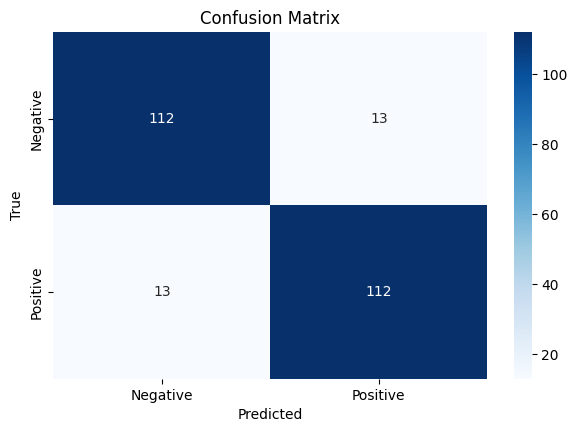

Accuracy: 0.90


In [ ]:
cm = confusion_matrix(y_test[:min(len(y_test), len(sentiment_results))], sentiment_results)
func.plot_confusion_matrix(cm, title="DistilBERT Sentiment Analysis")
accuracy = accuracy_score(y_test[:min(len(y_test), len(sentiment_results))], sentiment_results)
print(f"Accuracy: {accuracy:.2f}")

# OpenAI "gpt-3.5-turbo" for sentiment analysis:
- Instead of asking ChatGPT to summarize texts that are too long to be fed into the DistilBERT sentiment analysis, ask ChatGPT for a sentiment analysis on every movie review.

In [12]:
'''
def openai_sentiment_analysis(text):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Use "gpt-4" if needed
        messages=[
            {"role": "system", "content": "You are a helpful assistant that based on a text creates a sentiment analysis."},
            {"role": "user", "content": f"Create a sentiment analysis on this text: {text}. The answer from you should be either 'positive' or 'negative', always lowercase."},
            ],
        max_tokens=2,  # Limit the output to 500 tokens
        temperature=0.5  # Controls randomness, 0.5 is a balanced value
    )
    
    # Extract the summary from the response
    openai_sentiment_analysis = response['choices'][0]['message']['content']
    return openai_sentiment_analysis
'''

In [3]:
openai_sentiment_results = func.create_openai_sentiment_analysis(X_test)

I just saw this movie the other day when I rented 
positive
API calls: 1
I love the movie. It brought me back to the best t
positive
API calls: 2
Okay, just by reading the title you would think th
negative
API calls: 3
First off, this really is my favorite film ever. I
positive
API calls: 4
Being a completely broke film buff with a house to
negative
API calls: 5
Super Speedway makes a great demo of your new DVD 
positive
API calls: 6
This movie is not for everyone. You're either brig
positive
API calls: 7
I used to love the Muppets. The Muppet Movie, The 
negative
API calls: 8
Two houses, one street, one phone booth, one car, 
positive
API calls: 9
Oppenheimer was a GREAT series (it was the first t
positive
API calls: 10
I've been playing this movie incessantly this mont
positive
API calls: 11
When I was a kid, I loved "Tiny Toons". I especial
positive
API calls: 12
"Mararía" really disappointed me. I can't consider
negative
API calls: 13
This movie was awful in the worst way: you just

In [4]:
print(openai_sentiment_results[0].unique())

['positive' 'negative'
 'the sentiment analysis of the text is overwhelmingly negative.']


In [6]:
openai_sentiment_results_series = pd.Series(openai_sentiment_results[0]) # gör sen serie
openai_sentiment_results_series = openai_sentiment_results_series.apply(lambda x: x.replace("the sentiment analysis of the text is 'negative'.", "negative"))
openai_sentiment_results_series = openai_sentiment_results_series.apply(lambda x: x.replace('the sentiment analysis of the text is negative.', "negative"))
openai_sentiment_results_series = openai_sentiment_results_series.apply(lambda x: x.replace('the sentiment analysis of the text is overwhelmingly negative.', "negative"))
openai_sentiment_results_series.unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
openai_sentiment_results_series.to_csv(r"data\openai_sentiment_results_series_250.csv")

In [18]:
openai_sentiment_results_series = pd.read_csv(r"data\openai_sentiment_results_series_250.csv")
openai_sentiment_results_series = openai_sentiment_results_series['0']

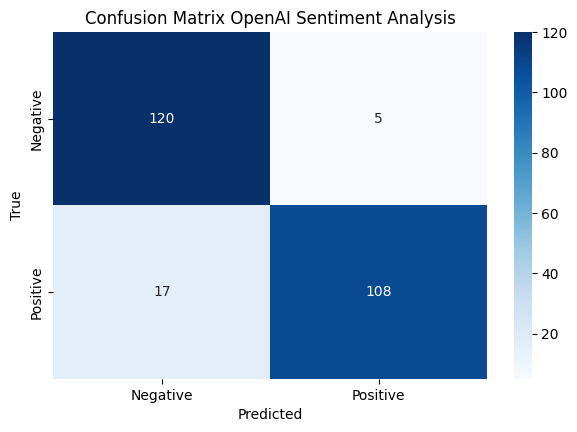

Accuracy: 0.91


In [19]:
cm = confusion_matrix(y_test[:min(len(y_test), len(openai_sentiment_results_series))], openai_sentiment_results_series)
func.plot_confusion_matrix(cm, title="OpenAI Sentiment Analysis")
accuracy = accuracy_score(y_test[:min(len(y_test), len(openai_sentiment_results_series))], openai_sentiment_results_series)
print(f"Accuracy: {accuracy:.2f}")

# OpenAI "gpt-4o-mini" for sentiment analysis:

In [10]:
x = X_test[1:3]
test_4 = func.create_openai_sentiment_analysis(x, model="gpt-4o-mini")

I love the movie. It brought me back to the best t
positive
API calls: 1
Okay, just by reading the title you would think th
negative
API calls: 2


In [11]:
gpt4_sentiment_results = func.create_openai_sentiment_analysis(X_test, model="gpt-4o-mini")

I just saw this movie the other day when I rented 
positive
API calls: 1
I love the movie. It brought me back to the best t
positive
API calls: 2
Okay, just by reading the title you would think th
negative
API calls: 3
First off, this really is my favorite film ever. I
positive
API calls: 4
Being a completely broke film buff with a house to
negative
API calls: 5
Super Speedway makes a great demo of your new DVD 
positive
API calls: 6
This movie is not for everyone. You're either brig
positive
API calls: 7
I used to love the Muppets. The Muppet Movie, The 
negative
API calls: 8
Two houses, one street, one phone booth, one car, 
negative
API calls: 9
Oppenheimer was a GREAT series (it was the first t
positive
API calls: 10
I've been playing this movie incessantly this mont
positive
API calls: 11
When I was a kid, I loved "Tiny Toons". I especial
positive
API calls: 12
"Mararía" really disappointed me. I can't consider
negative
API calls: 13
This movie was awful in the worst way: you just

In [12]:
print(gpt4_sentiment_results[0].unique())

['positive' 'negative'
 'the sentiment of the text is predominantly negative, with']


In [13]:
gpt4_sentiment_results_series = pd.Series(gpt4_sentiment_results[0]) # gör sen serie
gpt4_sentiment_results_series = gpt4_sentiment_results_series.apply(lambda x: x.replace("the sentiment of the text is predominantly negative, with", "negative"))
gpt4_sentiment_results_series.unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
cm = confusion_matrix(y_test[:min(len(y_test), len(openai_sentiment_results_series))], openai_sentiment_results_series)
func.plot_confusion_matrix(cm, title="OpenAI Sentiment Analysis")
accuracy = accuracy_score(y_test[:min(len(y_test), len(openai_sentiment_results_series))], openai_sentiment_results_series)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
#gpt4_sentiment_results_series.to_csv(r"..data\gpt4_sentiment_results_series_250.csv")

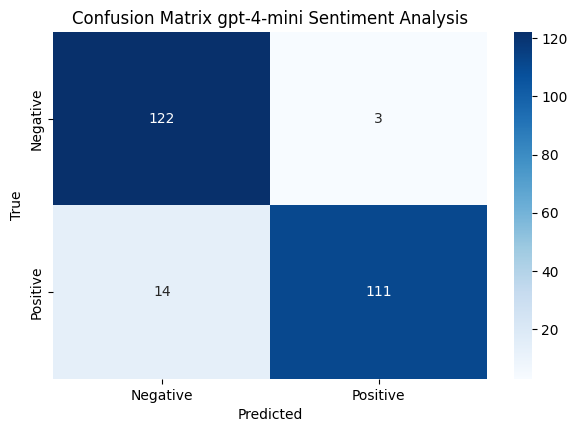

Accuracy: 0.93


In [18]:
cm = confusion_matrix(y_test[:min(len(y_test), len(gpt4_sentiment_results_series))], gpt4_sentiment_results_series)
func.plot_confusion_matrix(cm, title="gpt-4-mini Sentiment Analysis")
accuracy = accuracy_score(y_test[:min(len(y_test), len(gpt4_sentiment_results_series))], gpt4_sentiment_results_series)
print(f"Accuracy: {accuracy:.2f}")